In [30]:
import numpy as np
from ifxAvian import Avian
from ifxAvian.RadarTypes import DeviceConfig
import time
import matplotlib.pyplot as plt

# using for bgt60tr13c


In [31]:
print("Radar SDK Version: " + Avian.get_version())
Avian.__file__

fs = 400
frame_time = 1/fs
num_samples_per_chirp = 512

device = Avian.Device()


# set device config
config = Avian.DeviceConfig(
    sample_rate_Hz=1_000_000,       # ADC sample rate of 1MHZ
    rx_mask=5,                      # activate RX1 and RX3
    tx_mask=1,                      # activate TX1
    if_gain_dB=33,                  # gain of 33dB
    tx_power_level=31,              # TX power level of 31
    start_frequency_Hz=58e9,        # start frequency of chirp: 58 Ghz
    end_frequency_Hz=63.5e9,        # end frequency of chirp: 63.5 GHz
    num_chirps_per_frame=1,         # 1 chirps per frame
    # 512 samples per chirp # higher number = higher range resolution
    num_samples_per_chirp=num_samples_per_chirp,
    chirp_repetition_time_s=0.001,  # 1ms, as long as higher than num_samples_per_chirp * 1 us
    frame_repetition_time_s=1/fs,   # 5ms, frame_Rate = 200Hz
    hp_cutoff_Hz=80_000,            # 80kHz cutoff frequency for high-pass filter
    aaf_cutoff_Hz=500_000,          # Anti-aliasinf cutoff frequency of 500kHz
    mimo_mode='off'                 # MIMO disabled
)
# config.frame_repetition_time_s = 10000000


"""
5.5ghz bandwidth
1 mhz adc sampling rate
512 samples per chirp
1 chirp per frame
400 frame per second

range resolution = c/2b = 0.027m = 2.7cm
max range = 2.7cm * 512 / 2 =  6.912 m

"""

Radar SDK Version: 3.3.1


'\n5.5ghz bandwidth\n1 mhz adc sampling rate\n512 samples per chirp\n1 chirp per frame\n400 frame per second\n\nrange resolution = c/2b = 0.027m = 2.7cm\nmax range = 2.7cm * 512 / 2 =  6.912 m\n\n'

In [42]:
device.set_config(config)
ts = time.time()
#currently sampling at around 10
timestamps = []
frameData = []

time_in_sec_to_collect = 20*fs;

for frame_number in range(time_in_sec_to_collect):
    frame = device.get_next_frame()
    #num_rx_antennas, num_chirps_per_frame, num_samples_per_chirp = np.shape(
    #    frame)
    mat = frame[0, :, :]
    ts_now = time.time()-ts
    # print(ts_now)
    # print(np.shape(frame))
    timestamps.append(ts_now)
    frameData.append(mat)

frameData = np.array(frameData)
timestamps = np.array(timestamps)

print(np.shape(frameData))
print(np.shape(timestamps))

(8000, 1, 512)
(8000,)


In [43]:
#path = "F:\\UCSD\\Winter2023\\CSE237A\\FinalProj\\Github\\WaterSurfaceLevelSensing\\sampleData\\"
path = "D:\\UCSD\\Winter2023\\CSE237A\\WaterSurfaceLevelSensing-main\\sampleData\\"
# path = "C:\\Users\\baich\\Desktop\\02282023_mmwaveData\\"
fn = 'data_13.npz'
np.savez(path+fn, frameData=frameData, timestamps=timestamps,fs=fs)

#path = "F:\\UCSD\\Winter2023\\CSE237A\\FinalProj\\Github\\WaterSurfaceLevelSensing\\sampleData\\"
# path = "D:\\UCSD\\Winter2023\\CSE237A\\WaterSurfaceLevelSensing\\sampleData\\"

# fn = 'data_13.npz'
outfile = path+fn
npzfile = np.load(outfile)
frameData = npzfile['frameData']
timestamps = npzfile['timestamps']
# fs = npzfile['fs']
# fs = 400
# (100, 128, 64) 
# 100 frames, 128 chirps per frame, 64 adc samples per chirp
print(np.shape(frameData))
print(np.shape(timestamps))
print(np.shape(fs))

frameData = np.squeeze(frameData)
# frameData2 = np.sum(frameData, axis=1)
# print(np.shape(frameData2))

#mean normaliation to zero doppler nulling
frameData = frameData - np.mean(frameData, axis=0, keepdims=True)
print(np.shape(frameData))
fs=400

(8000, 1, 512)
(8000,)
()
(8000, 512)


(8000, 256)
(30, 8000)
(30, 8000)


Text(0.5, 0, 'Time (s)')

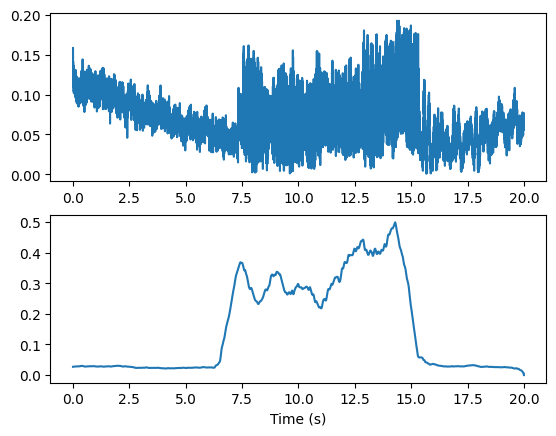

In [64]:
def movingVar(data,N):
    var = []
    for i in range(np.shape(data)[0]):
        var.append( np.var(data[i:i+N]))
    var = np.array(var)
    return var
def movingMean(data,N):
    var = []
    for i in range(np.shape(data)[0]):
        var.append( np.average(data[i:i+N]))
    var = np.array(var)
    return var

data = np.fft.fft(frameData, axis=1)
data = data[:,:int(data.shape[1]/2)]
print(np.shape(data))

# amp = np.abs(data[:,0:30]).T
# phase = np.angle(data[:,0:30]).T
partData = data[:,0:30].T
amp = np.abs(partData)
phase = np.angle(partData)
print(np.shape(amp))
print(np.shape(phase))

plt.figure();
# plt.subplot(2,1,1)
# plt.imshow(amp, cmap=plt.cm.jet, aspect="auto")

# print(np.max(np.max(amp)))

# plt.figure()
# plt.imshow(phase, cmap=plt.cm.jet, aspect="auto")


xT = np.linspace(0, int(np.shape(amp)[1]*frame_time),np.shape(amp)[1])

plt.subplot(2,1,1)
plt.plot(xT,amp[8,:])
plt.subplot(2,1,2)
rst = movingVar(amp[8,:],20)
rst = rst-np.min(rst)
rst = rst/np.max(rst)
rst = movingMean(rst,400)
plt.plot(xT,rst)
plt.xlabel("Time (s)")

20.0
